In [1]:
import pennylane as qml
from pennylane import numpy as np

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
#make a 7qubit device
dev = qml.device("default.qubit", wires=4, shots=100)

In [3]:
#state prepration template
def data_prepration(d):

    for i,j in enumerate(d):
        r = j/510
        qml.RY(r*np.pi, wires=i)
    
    qml.Barrier(wires=(len(d)-1,0))

In [4]:
#inverce MERA and fully entangler layer's template
def inverce_MERA(p):

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.CNOT(wires=(0,1))
    qml.CNOT(wires=(1,2))
    qml.CNOT(wires=(2,3))
    qml.CNOT(wires=(3,0))

    qml.Barrier(wires=(0,3))
    
    qml.CRZ(p[0],wires=(1,0))
    qml.CRX(p[1],wires=(1,0))

    qml.CRZ(p[2],wires=(3,2))
    qml.CRX(p[3],wires=(3,2))

    qml.CRZ(p[4],wires=(2,0))
    qml.CRX(p[5],wires=(2,0))

In [5]:
#configure circuit in a qnode using dev
@qml.qnode(dev)
def inverce_MERA_layer(inputs, mera_parameters):

    data_prepration(inputs)

    inverce_MERA(mera_parameters)

    return qml.expval(qml.PauliZ(0))

In [6]:
#define hyper_parameters and weights-init
np.random.seed(0)
random_trash_data = np.random.rand(4, requires_grad=True)
weights_init = 0.01 * np.random.randn(6, requires_grad=True)

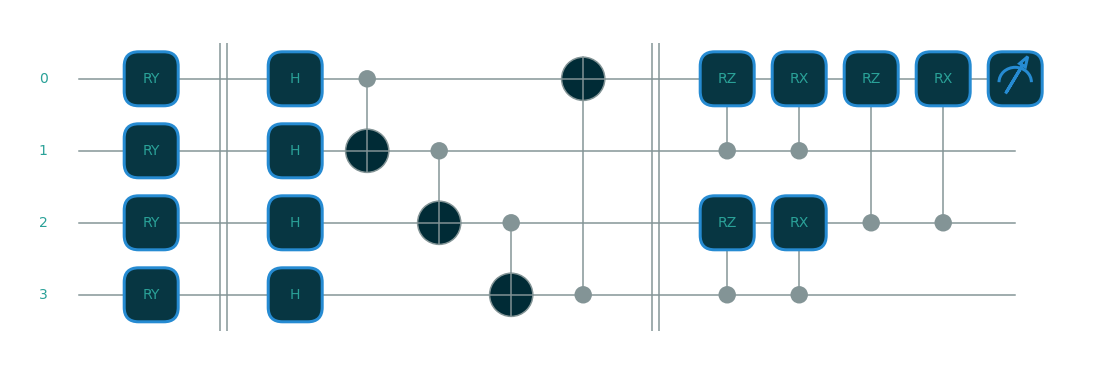

In [7]:
#needs weights_inits hyperparameter
qml.drawer.use_style(style="solarized_dark")
fig, ax = qml.draw_mpl(inverce_MERA_layer)(random_trash_data ,weights_init)

# create pytorch layer from Qnode 

In [8]:
weight_shapes = {"mera_parameters": 6}
qlayer = qml.qnn.TorchLayer(inverce_MERA_layer, weight_shapes)

# working with data

In [9]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
# X_train.targets = (X_train.targets[idx]*2) + (np.ones(200)*(-1))

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

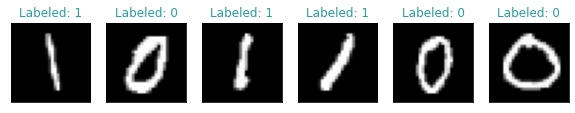

In [10]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [11]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
# X_test.targets = (X_test.targets[idx]*2) + (np.ones(100)*(-1))

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Creating the Hybrid Neural Network 

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 4)
        self.qnode = qlayer
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnode(x)
        x = x.view(1, -1)
        return torch.cat((x, 1 - x), -1)

# train

In [13]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.8031
Training [10%]	Loss: -1.3218
Training [15%]	Loss: -1.3730
Training [20%]	Loss: -1.3993
Training [25%]	Loss: -1.4221
Training [30%]	Loss: -1.4412
Training [35%]	Loss: -1.4457
Training [40%]	Loss: -1.4551
Training [45%]	Loss: -1.4637
Training [50%]	Loss: -1.4667
Training [55%]	Loss: -1.4693
Training [60%]	Loss: -1.4775
Training [65%]	Loss: -1.4792
Training [70%]	Loss: -1.4797
Training [75%]	Loss: -1.4807
Training [80%]	Loss: -1.4800
Training [85%]	Loss: -1.4826
Training [90%]	Loss: -1.4863
Training [95%]	Loss: -1.4880
Training [100%]	Loss: -1.4881


Text(0, 0.5, 'Neg Log Likelihood Loss')

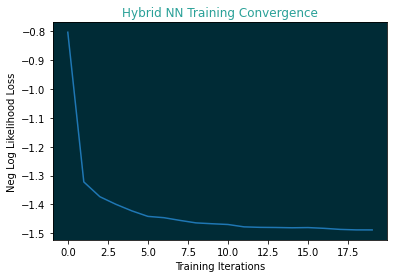

In [18]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

# test and rsualt

In [19]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=-1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -1.4861
	Accuracy: 100.0%


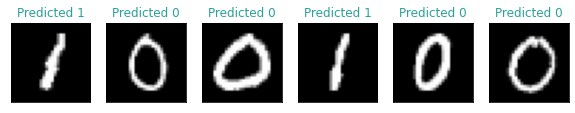

In [21]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1